# Analyzing Global Trust: A Sample Analysis

Based on https://ourworldindata.org/grapher/self-reported-trust-attitudes

A more complete analysis including the data preparation can be found in the file `analyzing_data_on_trust_full.ipynb` in the folder `results`.

## Our Research Question

**"How do trust attitudes vary between countries, and what patterns can we discover in the data?"**

## Import necessary libraries

In [1]:
import urllib.request
import csv
import statistics
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt


## Load the prepared dataset

In [2]:
# Download the latest version of the CSV file from the URL and save it locally
url = 'https://raw.githubusercontent.com/quadriga-dk/OER-Workshop/refs/heads/main/assets/cleaned_trust_data.csv'
response = urllib.request.urlopen(url)
data = response.read().decode('utf-8')
with open('../assets/cleaned_trust_data.csv', 'w') as file:
    file.write(data)

# Load the cleaned trust data from the downloaded CSV file
with open('../assets/cleaned_trust_data.csv', 'r') as trust_data_file:
    survey_data = list(csv.DictReader(trust_data_file))


## First look at the data

In [3]:
# Let's see what our cleaned data looks like
print("\n🎯 Our cleaned data structure:")
print("Each observation now has exactly 3 pieces of information:")
for i, observation in enumerate(survey_data[:5]):
    print(f"  {i+1}. {observation}")

# Convert Trust_Percentage from str to float for calculations
for obs in survey_data:
    obs['Trust_Percentage'] = float(obs['Trust_Percentage'])

print("After transforming 'Trust_Percentage' to a floating point number:")
for i, observation in enumerate(survey_data[:5]):
    print(f"  {i+1}. {observation}")

print(f"\n📊 Dataset summary:")
countries = [obs['Country'] for obs in survey_data]
trust_values = [obs['Trust_Percentage'] for obs in survey_data]
years = [obs['Year'] for obs in survey_data if obs['Year']]

print(f"   🌍 Countries covered: {len(set(countries))}")
print(f"   📅 Time period: {min(years) if years else 'N/A'} - {max(years) if years else 'N/A'}")
print(f"   📈 Trust range: {min(trust_values):.1f}% to {max(trust_values):.1f}%")


🎯 Our cleaned data structure:
Each observation now has exactly 3 pieces of information:
  1. {'Country': 'Albania', 'Year': '2004', 'Trust_Percentage': '23.2'}
  2. {'Country': 'Albania', 'Year': '2010', 'Trust_Percentage': '9.221174'}
  3. {'Country': 'Albania', 'Year': '2022', 'Trust_Percentage': '2.77237'}
  4. {'Country': 'Algeria', 'Year': '2004', 'Trust_Percentage': '10.76443'}
  5. {'Country': 'Algeria', 'Year': '2014', 'Trust_Percentage': '17.16667'}
After transforming 'Trust_Percentage' to a floating point number:
  1. {'Country': 'Albania', 'Year': '2004', 'Trust_Percentage': 23.2}
  2. {'Country': 'Albania', 'Year': '2010', 'Trust_Percentage': 9.221174}
  3. {'Country': 'Albania', 'Year': '2022', 'Trust_Percentage': 2.77237}
  4. {'Country': 'Algeria', 'Year': '2004', 'Trust_Percentage': 10.76443}
  5. {'Country': 'Algeria', 'Year': '2014', 'Trust_Percentage': 17.16667}

📊 Dataset summary:
   🌍 Countries covered: 116
   📅 Time period: 2004 - 2022
   📈 Trust range: 2.1% to 7

## Exploring Our Data - First Discoveries

Now the fun begins! Let's start exploring our data to understand what we're working with. This is like being a detective - we're looking for clues and patterns.

In [4]:
print("\n🔍 Making Our First Discoveries")
print("-" * 42)

# Extract our key variables for easy analysis
countries = [obs['Country'] for obs in survey_data]
trust_percentages = [obs['Trust_Percentage'] for obs in survey_data]
years = [obs['Year'] for obs in survey_data if obs['Year']]

print("🌡️ Taking the temperature of global trust...")

# Basic statistics - our first clues!
avg_trust = statistics.mean(trust_percentages)
median_trust = statistics.median(trust_percentages)
min_trust = min(trust_percentages)
max_trust = max(trust_percentages)
trust_spread = max_trust - min_trust

print(f"\n📊 Global Trust Statistics:")
print(f"   🎯 Average trust level: {avg_trust:.1f}%")
print(f"   📐 Median trust level: {median_trust:.1f}%") 
print(f"   📉 Lowest trust observed: {min_trust:.1f}%")
print(f"   📈 Highest trust observed: {max_trust:.1f}%")
print(f"   📏 Total variation: {trust_spread:.1f} percentage points")
print(f"   📏 Std. deviation: {statistics.stdev(trust_percentages):.1f}")

print(f"\n🧮 What this means:")
if avg_trust > 50:
    print(f"   💚 Globally, people tend to be trusting (average > 50%)")
elif avg_trust > 30:
    print(f"   🟡 Globally, people show moderate trust levels")
else:
    print(f"   ❤️‍🩹 Globally, trust levels are quite low")

print(f"   🌊 Trust varies dramatically between countries ({trust_spread:.0f} percentage points range)")

# Let's peek at a few specific examples
print(f"\n👀 Sneak peek at our data:")
print("Here are five randomly sampled observations in our dataset:")

for i, obs in enumerate(random.sample(survey_data, 5)):
    year_str = f" in {obs['Year']}" if obs['Year'] else ""
    print(f"   - {obs['Country']}{year_str}: {obs['Trust_Percentage']:.1f}% trust")


🔍 Making Our First Discoveries
------------------------------------------
🌡️ Taking the temperature of global trust...

📊 Global Trust Statistics:
   🎯 Average trust level: 25.5%
   📐 Median trust level: 22.2%
   📉 Lowest trust observed: 2.1%
   📈 Highest trust observed: 74.9%
   📏 Total variation: 72.8 percentage points
   📏 Std. deviation: 15.8

🧮 What this means:
   ❤️‍🩹 Globally, trust levels are quite low
   🌊 Trust varies dramatically between countries (73 percentage points range)

👀 Sneak peek at our data:
Here are five randomly sampled observations in our dataset:
   - Montenegro in 2004: 32.9% trust
   - India in 2010: 20.7% trust
   - Uruguay in 2022: 14.5% trust
   - China in 2004: 52.5% trust
   - Netherlands in 2004: 59.4% trust


## The Trust Champions and Skeptics

Let's find out which countries are the most trusting and which are the most skeptical. This is where we start to see interesting patterns!

In [5]:
print("\n🏆 Discovering Trust Champions and Skeptics")
print("-" * 52)

# Calculate average trust by country (some countries may have multiple years)
country_trust_data = defaultdict(list)
for obs in survey_data:
    country_trust_data[obs['Country']].append(obs['Trust_Percentage'])

# Get the average trust for each country
country_averages = {}
for country, trust_values in country_trust_data.items():
    country_averages[country] = statistics.mean(trust_values)

# Sort countries by trust level
trust_ranking = sorted(country_averages.items(), key=lambda x: x[1], reverse=True)

print("🥇 THE TRUST CHAMPIONS (Most Trusting Countries)")
print("These countries have the highest levels of interpersonal trust:")
for rank, (country, avg_trust) in enumerate(trust_ranking[:5], 1):
    data_points = len(country_trust_data[country])
    print(f"   {rank}. {country}: {avg_trust:.1f}% trust (based on {data_points} observations)")

print(f"\n🤔 THE TRUST SKEPTICS (Least Trusting Countries)")
print("These countries show more cautious attitudes toward trusting others:")
for rank, (country, avg_trust) in enumerate(trust_ranking[-5:], 1):
    data_points = len(country_trust_data[country])
    print(f"   {rank}. {country}: {avg_trust:.1f}% trust (based on {data_points} observations)")

# Calculate how many countries fall into different trust categories
high_trust_countries = sum(1 for _, trust in trust_ranking if trust >= 50)
medium_trust_countries = sum(1 for _, trust in trust_ranking if 30 <= trust < 50)
low_trust_countries = sum(1 for _, trust in trust_ranking if trust < 30)

total_countries = len(trust_ranking)

print(f"\n📊 TRUST LANDSCAPE OVERVIEW:")
print(f"   🟢 High trust countries (≥50%): {high_trust_countries}/{total_countries} ({high_trust_countries/total_countries*100:.1f}%)")
print(f"   🟡 Medium trust countries (30-49%): {medium_trust_countries}/{total_countries} ({medium_trust_countries/total_countries*100:.1f}%)")
print(f"   🔴 Low trust countries (<30%): {low_trust_countries}/{total_countries} ({low_trust_countries/total_countries*100:.1f}%)")

# Look for interesting patterns
nordic_countries = ['Norway', 'Sweden', 'Denmark', 'Finland']
nordic_in_data = [country for country in nordic_countries if country in country_averages]

if len(nordic_in_data) >= 2:
    nordic_trust = statistics.mean([country_averages[country] for country in nordic_in_data])
    print(f"\n🌲 NORDIC PATTERN DETECTED:")
    print(f"   Nordic countries ({', '.join(nordic_in_data)}) average: {nordic_trust:.1f}%")
    print(f"   That's {nordic_trust - avg_trust:.1f} percentage points above the global average!")


🏆 Discovering Trust Champions and Skeptics
----------------------------------------------------
🥇 THE TRUST CHAMPIONS (Most Trusting Countries)
These countries have the highest levels of interpersonal trust:
   1. Norway: 72.7% trust (based on 2 observations)
   2. Denmark: 71.0% trust (based on 3 observations)
   3. Sweden: 62.6% trust (based on 4 observations)
   4. Finland: 61.7% trust (based on 3 observations)
   5. Netherlands: 59.2% trust (based on 4 observations)

🤔 THE TRUST SKEPTICS (Least Trusting Countries)
These countries show more cautious attitudes toward trusting others:
   1. Ecuador: 6.5% trust (based on 2 observations)
   2. Philippines: 5.6% trust (based on 3 observations)
   3. Northern Cyprus: 4.7% trust (based on 1 observations)
   4. Nicaragua: 4.2% trust (based on 1 observations)
   5. Trinidad and Tobago: 3.5% trust (based on 2 observations)

📊 TRUST LANDSCAPE OVERVIEW:
   🟢 High trust countries (≥50%): 10/116 (8.6%)
   🟡 Medium trust countries (30-49%): 20/11

## Visualizing Trust Patterns

A picture is worth a thousand data points! Let's create visualizations to see the patterns in our trust data.


📈 Painting the Picture of Global Trust
-----------------------------------------------
🎨 Creating Chart 1: Trust Champions...
🎨 Creating Chart 2: Trust Distribution...
🎨 Creating Chart 3: Time Trends...
🎨 Creating Chart 4: Trust Categories...


/var/folders/wf/xl2y4ql54z75yt8dr2whsc5r0000gn/T/ipykernel_57751/1064000120.py:118: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/xl2y4ql54z75yt8dr2whsc5r0000gn/T/ipykernel_57751/1064000120.py:118: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/xl2y4ql54z75yt8dr2whsc5r0000gn/T/ipykernel_57751/1064000120.py:118: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/xl2y4ql54z75yt8dr2whsc5r0000gn/T/ipykernel_57751/1064000120.py:118: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/xl2y4ql54z75yt8dr2whsc5r0000gn/T/ipykernel_57751/1064000120.py:118: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/xl2y4ql54z75yt8dr2whsc5r0000gn/T/ipykernel_57751/1064000

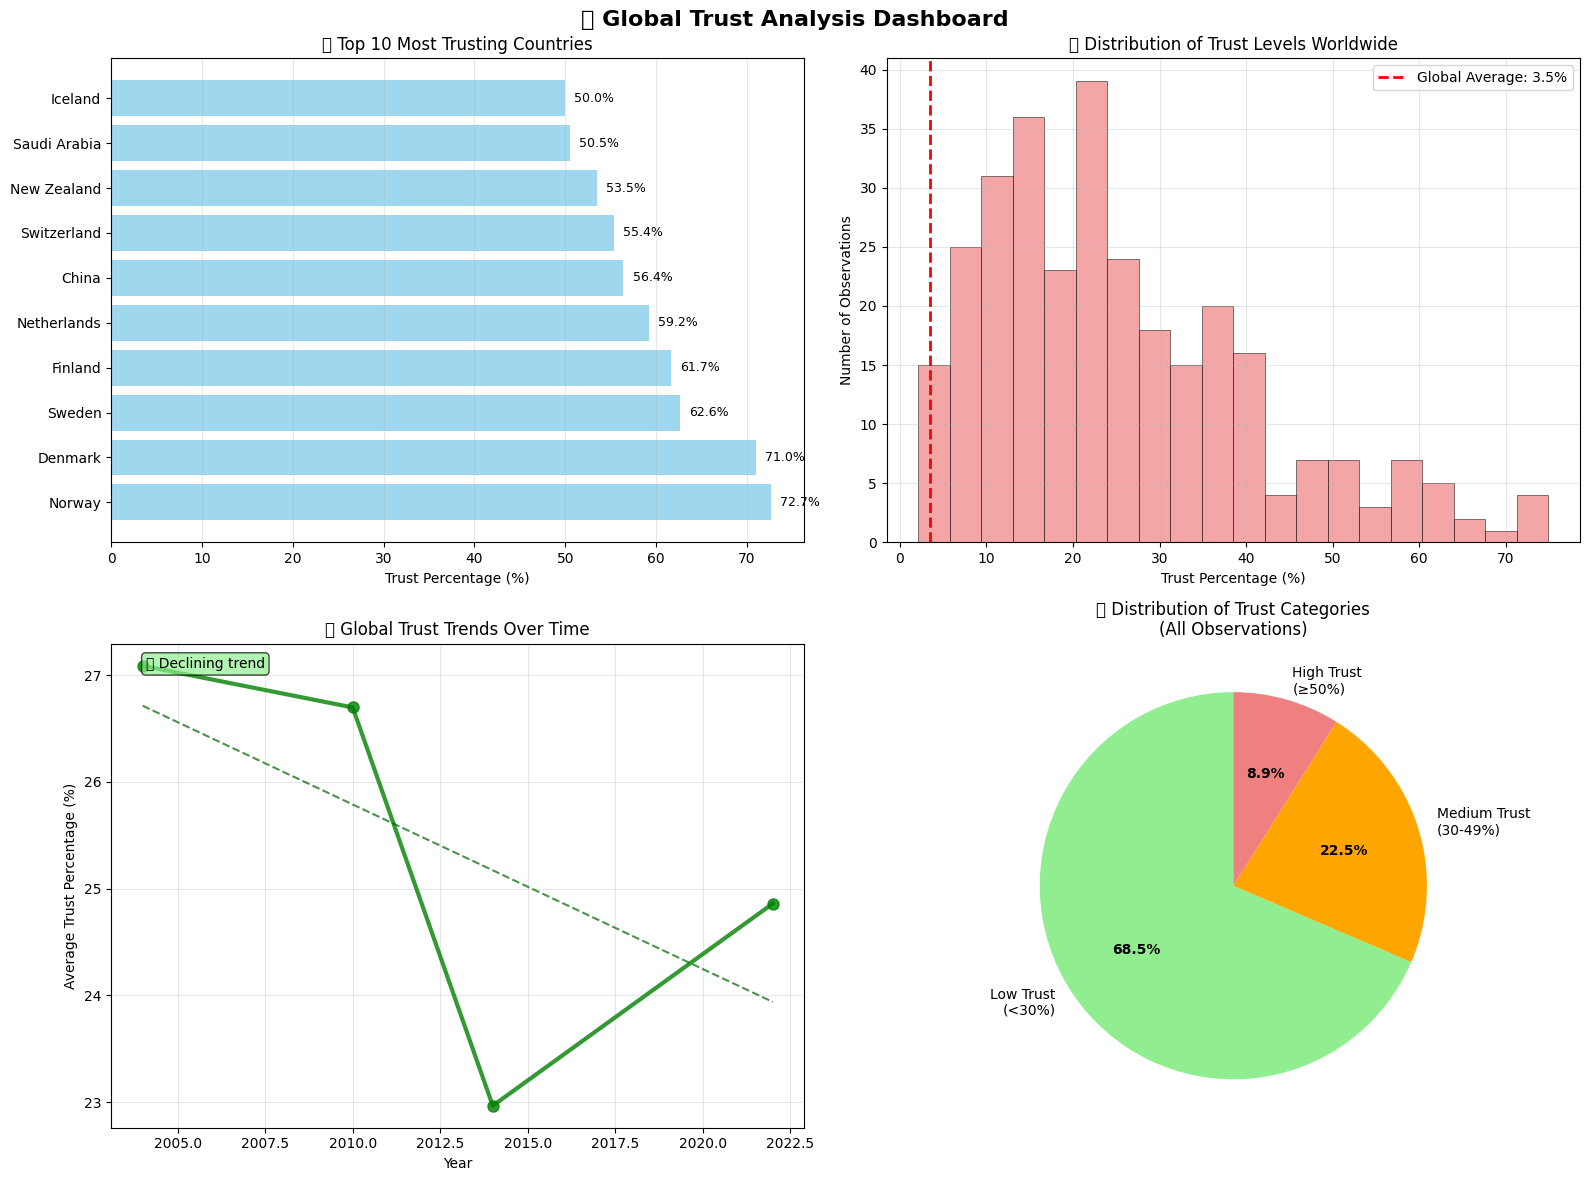

✨ Visualization complete! What patterns do you notice?


In [6]:
print("\n📈 Painting the Picture of Global Trust")
print("-" * 47)

# Create our visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🌍 Global Trust Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

# --- CHART 1: Trust Champions Bar Chart ---
print("🎨 Creating Chart 1: Trust Champions...")

top_10_countries = trust_ranking[:10]
countries_names = [item[0] for item in top_10_countries]
countries_trust = [item[1] for item in top_10_countries]

bars = axes[0, 0].barh(range(len(countries_names)), countries_trust, color='skyblue', alpha=0.8)
axes[0, 0].set_yticks(range(len(countries_names)))
axes[0, 0].set_yticklabels(countries_names)
axes[0, 0].set_xlabel('Trust Percentage (%)')
axes[0, 0].set_title('🏆 Top 10 Most Trusting Countries')
axes[0, 0].grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, countries_trust)):
    axes[0, 0].text(value + 1, i, f'{value:.1f}%', va='center', fontsize=9)

# --- CHART 2: Trust Distribution Histogram ---
print("🎨 Creating Chart 2: Trust Distribution...")

n_bins = min(20, len(set(trust_percentages)))  # Adaptive bin count
axes[0, 1].hist(trust_percentages, bins=n_bins, color='lightcoral', alpha=0.7, 
                edgecolor='black', linewidth=0.5)
axes[0, 1].axvline(avg_trust, color='red', linestyle='--', linewidth=2, 
                   label=f'Global Average: {avg_trust:.1f}%')
axes[0, 1].set_xlabel('Trust Percentage (%)')
axes[0, 1].set_ylabel('Number of Observations')
axes[0, 1].set_title('📊 Distribution of Trust Levels Worldwide')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# --- CHART 3: Time Trends (if we have year data) ---
print("🎨 Creating Chart 3: Time Trends...")

if years and len(set(years)) > 1:
    # Group data by year and calculate averages
    yearly_data = defaultdict(list)
    for obs in survey_data:
        if int(obs['Year']):
            yearly_data[int(obs['Year'])].append(float(obs['Trust_Percentage']))
    
    years_sorted = sorted(yearly_data.keys())
    yearly_averages = [statistics.mean(yearly_data[year]) for year in years_sorted]
    
    axes[1, 0].plot(years_sorted, yearly_averages, marker='o', linewidth=3, 
                    markersize=8, color='green', alpha=0.8)
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Average Trust Percentage (%)')
    axes[1, 0].set_title('📈 Global Trust Trends Over Time')
    axes[1, 0].grid(alpha=0.3)
    
    # Add trend line
    if len(years_sorted) > 2:
        # Simple linear trend
        x_mean = statistics.mean(years_sorted)
        y_mean = statistics.mean(yearly_averages)
        
        # Calculate slope
        numerator = sum((x - x_mean) * (y - y_mean) for x, y in zip(years_sorted, yearly_averages))
        denominator = sum((x - x_mean) ** 2 for x in years_sorted)
        
        if denominator != 0:
            slope = numerator / denominator
            intercept = y_mean - slope * x_mean
            
            trend_line = [slope * x + intercept for x in years_sorted]
            axes[1, 0].plot(years_sorted, trend_line, '--', color='darkgreen', alpha=0.7)
            
            trend_direction = "📈 Rising" if slope > 0 else "📉 Declining" if slope < 0 else "➡️ Stable"
            axes[1, 0].text(0.05, 0.95, f'{trend_direction} trend', transform=axes[1, 0].transAxes,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

else:
    # Alternative: Show country ranking scatter plot
    axes[1, 0].scatter(range(len(countries_trust)), countries_trust, alpha=0.6, s=100, color='purple')
    axes[1, 0].set_ylabel('Trust Percentage (%)')
    axes[1, 0].set_xlabel('Country Ranking')
    axes[1, 0].set_title('🔢 Trust Levels by Country Ranking')
    axes[1, 0].grid(alpha=0.3)

# --- CHART 4: Trust Categories Pie Chart ---
print("🎨 Creating Chart 4: Trust Categories...")

# Categorize all our observations
def categorize_trust(trust_level):
    if trust_level >= 50:
        return 'High Trust\n(≥50%)'
    elif trust_level >= 30:
        return 'Medium Trust\n(30-49%)'
    else:
        return 'Low Trust\n(<30%)'

trust_categories = [categorize_trust(trust) for trust in trust_percentages]
category_counts = Counter(trust_categories)

colors = ['lightgreen', 'orange', 'lightcoral']
wedges, texts, autotexts = axes[1, 1].pie(category_counts.values(), 
                                          labels=category_counts.keys(), 
                                          autopct='%1.1f%%', 
                                          colors=colors, 
                                          startangle=90,
                                          textprops={'fontsize': 10})

axes[1, 1].set_title('🥧 Distribution of Trust Categories\n(All Observations)')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

print("✨ Visualization complete! What patterns do you notice?")